In [1]:
import subprocess
import pdb

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from nilearn.plotting import view_img_on_surf, view_img
from scipy.stats import ttest_1samp

import networkx as nx
from IPython.display import HTML

# import nest_asyncio
# nest_asyncio.apply()
# import datalad.api as dl

import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import scipy.io
from scipy import stats

from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance
from sklearn.preprocessing import RobustScaler, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime as dt
from scipy.signal import hilbert, butter, filtfilt
from kuramoto import Kuramoto, plot_phase_coherence, plot_activity

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")


/Users/gracer/opt/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/gracer/opt/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.

Autosaving every 5 seconds


Autosaving every 5 seconds


In [2]:
labels = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/CIT168_Reinf_Learn_v1.1.0/labels.csv'
bbasepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base'
clamppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp'
ppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/'

In [4]:
ROI_names = pd.read_csv(labels,sep = ',')
heads = list(ROI_names['ROI'])

In [6]:
ROI_names['ROI']

0        Pu
1        Ca
2       NAC
3       EXA
4       GPe
5       GPi
6       SNc
7        RN
8       SNr
9       PBP
10      VTA
11      VeP
12       HN
13      HTH
14       MN
15      STH
16    dlPFC
17      Viz
18    Hippo
Name: ROI, dtype: object

# Important functions

In [3]:
def get_subject_roi(data, roi):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub][roi]
    return pd.DataFrame(sub_rois)

# Standardizing the timeseries (brain and insulin seperately)
Switch to both robust, ~~then seperate the negative (abs) and postive values~~, then run through the pipeline.
4/27 had to switch both to standard cause robust obliterated the insulin

In [2]:
def combo(path2ts, path2insulin, outpath, instatus):
    prets = pd.read_csv(path2ts, sep = '  ', header = None)
    print(prets.shape)
    x = prets.shape[1]
    if x > len(heads):
#         pdb.set_trace()
        if x - len(heads) == 2:
            cols = [-2,-1]
            prets = prets.drop(prets.columns[cols],axis=1)
        if x - len(heads) == 1:
            cols = [-1]
            prets = prets.drop(prets.columns[cols],axis=1)
    transformer = StandardScaler().fit(prets)
    ts = pd.DataFrame(data = transformer.transform(prets))
    ts = ts.set_axis(heads, axis=1, inplace=False)
    ts['TR'] = ts.index
    ts['TR'] = pd.to_datetime(ts['TR'], unit='s')
    ts_downsamp = ts.set_index('TR').resample('60S').mean().dropna().reset_index()
    ts_downsamp = ts_downsamp.rename({'TR': 'time'}, axis=1)
    df = ts_downsamp
    print(df.shape)
    
    if instatus == "clamp":
        in_ts = pd.read_csv(path2insulin, sep = ',', encoding='latin-1')
        ins = np.array(in_ts['insulin_uIU_mL']).reshape(-1, 1)
        inscaler = StandardScaler()
        X = pd.DataFrame(inscaler.fit_transform(ins))
        
        gluc = np.array(in_ts['glucose_mg_dL']).reshape(-1, 1)
        gluscaler = StandardScaler()
        Y = pd.DataFrame(gluscaler.fit_transform(gluc))

        in_ts['insulin_uIU_mL'] = X
        in_ts['glucose_mg_dL'] = Y
        
        in_ts['time'] = in_ts['time'] - 1
        in_ts['time'] = pd.to_datetime(in_ts['time'], unit='m')

        df = pd.merge(df, in_ts, on='time', how='outer')
        df = df.drop(['label','sex','pid'], 1)
        df.drop(df.index[:4], inplace=True)
        
    fp = outpath
    df.to_csv(fp, index=False)

Read in the corrlabel_ts.txt (this is the timeseries). The combo function will scale the data, downsample the imaging data, and create a csv file called total_ts.csv

In [14]:
tasks = ['base','clamp']

In [15]:
for task in tasks:
    for sub_path in glob.glob(os.path.join(ppath,'%s'%task,'*')):
        print(sub_path)
        sub = sub_path.split('/')[-1]
        style = sub_path.split('/')[-2]
        path2ts = os.path.join(sub_path,'corrlabel_ts.txt')
        path2insulin = os.path.join('/Users/gracer/Documents/BBC_21-2939_insulin','%s.csv'%sub)
        outpath = os.path.join(sub_path,'total_ts.csv')
        combo(path2ts, path2insulin, outpath, style)

/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20008
(600, 21)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20001
(600, 21)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20002
(600, 21)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20003
(600, 21)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20004
(600, 20)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20010
(600, 21)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20008
(2784, 21)
(47, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20001
(2794, 21)
(47, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002
(3600, 21)
(60, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20003
(3600, 21)
(60, 20)
/Users/gracer/Document

Drop excess columns and then drop na

In [19]:
sub_timeseries_w_na = {}
for txtfile in glob.glob(os.path.join(clamppath,'*','total_ts.csv')):
    print(txtfile)
    df = pd.read_csv(txtfile)
    sub = txtfile.split('/')[-2]
#     df.reset_index(inplace=True, drop=True)
    df = df.set_index('time')
    df = df.drop(['PBP','VTA','SNr','glucose_mg_dL'], 1)
    sub_timeseries_w_na[sub] = df


/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20008/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20001/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20003/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20004/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20010/total_ts.csv


In [20]:
heady = list(sub_timeseries_w_na['20001'].columns.values)

In [21]:
sub_timeseries = {}
for sub,data in sub_timeseries_w_na.items():
    print(sub)
    sub_timeseries[sub] = data.dropna()

20008
20001
20002
20003
20004
20010


# Time syncrony
This is the meat of the analysis stream, here we will calculated the synchonicity between each subject's roi and insulin.  
https://naturalistic-data.org/content/Intersubject_Correlation.html#intersubject-phase-synchrony-tutorial

## Custom functions
These aren't all custom, but I did break apart several existing functions to cobble them back together how I wanted

In [9]:
def _phase_vector_length_sine_only(phase_angles):
    """
    Only going to get the sine of the phase_angles
    Compute vector length of phase angles using circular statistics

    Can take 1D (observation for a single feature) or 2D (observation x feature) signals

    Implementation from:

        Fisher, N. I. (1995). Statistical analysis of circular data. cambridge university press.

    Args:
        phase_angles: (np.array) 1D or 2D array of phase angles

    Returns:
         phase angle vector length: (np.array)

    """

    axis = 0 if len(phase_angles.shape) == 1 else 1
    return np.float32(
#             np.mean(np.cos(phase_angles), axis=axis) ** 2 +
              np.mean(np.sin(phase_angles), axis=axis))

In [10]:
def b_bandpass_filter(data, low_cut, high_cut, fs, axis=0, order=5):
    """
    Apply a bandpass butterworth filter with zero-phase filtering

    Args:
        data: (np.array)
        low_cut: (float) lower bound cutoff for high pass filter
        high_cut: (float) upper bound cutoff for low pass filter
        fs: (float) sampling frequency in Hz
        axis: (int) axis to perform filtering.
        order: (int) filter order for butterworth bandpass

    Returns:
        bandpass filtered data.
    """
    nyq = 0.5 * fs
    b, a = butter(order, [low_cut / nyq, high_cut / nyq], btype="band")
    return filtfilt(b, a, data, axis=axis)

In [11]:
def isps_insulin(data, pairwise=False):
    #Updated with sine only phase 
    if not isinstance(data, (pd.DataFrame, np.ndarray)):
        raise ValueError("data must be a pandas dataframe or numpy array (observations by subjects)")
    phase = np.angle(hilbert(pd.DataFrame(data), axis=0))
    out = {"average_angle": _phase_mean_angle(phase)}
    out["vector_length"] = _phase_vector_length_sine_only(phase)
    return out


In [12]:
def _phase_rayleigh_p(phase_angles):
    """Compute the p-value of the phase_angles using the Rayleigh statistic

    Note: this test assumes every time point is independent, which is unlikely to be true in a timeseries with autocorrelation

    Implementation from:

        Fisher, N. I. (1995). Statistical analysis of circular data. cambridge university press.

    Args:
        phase_angles: (np.array) 1D or 2D array of phase angles

    Returns:
         p-values: (np.array)

    """

    n = len(phase_angles) if len(phase_angles.shape) == 1 else phase_angles.shape[1]

    Z = n * _phase_vector_length(phase_angles) ** 2
    if n <= 50:
        return np.exp(-1 * Z) * (
            1
            + (2 * Z - Z ** 2) / (4 * n)
            - (24 * Z - 132 * Z ** 2 + 76 * Z ** 3 - 9 * Z ** 4) / (288 * n ** 2)
        )
    else:
        return np.exp(-1 * Z)

In [31]:
from datetime import datetime 
import pickle
from time import time

In [32]:
def adillyofapickle(basepath,dic, name):
    datefmt='%m-%d-%Y_%I-%M-%S'
    st = datetime.fromtimestamp(time()).strftime(datefmt)
    if os.path.exists(os.path.join(basepath,'tmp')):
        print('already have tmp')
    else:
        os.makedirs(os.path.join(basepath,'tmp'))
    pickle.dump(dic, open(os.path.join(basepath,'tmp','%s_%s'%(name,st)), 'wb'), protocol=4)


In [17]:
def onetoughjar(path2dic):
    with open(path2dic, 'rb') as pickle_file:
        try:
            while True:
                output = pickle.load(pickle_file)
        except EOFError:
            pass
    return(output)

## About frequencies
* intrinsic mode functions (IMFs)
* variational mode decomposition (VMD)  
(1) estimate individual IMFs by computing the Hilbert transform of the original signal f  
(2) shift each mode to its base frequency using heterodyne demodulation  
(3) estimate the bandwidth of each mode as the H1 Gaussian smoothness of the demodulated signal.

The frequencies used in this analysis are dervived from (10.3389/fnins.2019.00900). They found 4 frequencies. 
* VMD IMF1: 0.20–0.24 Hz
* VMD IMF2: 0.13–0.17 Hz
* VMD IMF3: 0.063–0.098 Hz
* VMD IMF4: 0.021–0.036 Hz  
Their results are summarized here: IMF4 being the most stable across brain regions and IMF2 being the least. Highest correlations between brain regions are found using IMF4, followed by IMF3, while no strong patterns were seen for IMFs 1 and 2. We have identified the frequency cluster IMF3 as most representative of neutrally relevant BOLD, both by frequency and by spatial contribution.

## Get the phases of the rois
This will get the phases for each roi per subject. This is using a bandpass filter and the hilbert transform in line with previous methods. 

In [22]:
phaze = {}
tr = 1
time = {}
out = {}
frequencies = [(0.021, 0.036),(0.063, 0.098),(0.13, 0.17),(0.2, 0.25)]
frq = ['IMF4: 0.021–0.036 Hz','IMF3: 0.063–0.098 Hz','IMF2: 0.13–0.17 Hz','IMF1: 0.20–0.25 Hz']
for roi in heady[0:-1]:
    print(roi)
    df = get_subject_roi(sub_timeseries, roi).dropna()
    names = df.columns
    time[roi] = df.index
    phaze[roi]={}
    for name in names:
        phaze[roi][name]={}
        for x, freq in enumerate(frequencies):
            phaze[roi][name][frq[x]] = np.angle(
                hilbert(b_bandpass_filter(get_subject_roi(sub_timeseries, roi).dropna()[name], low_cut=freq[0], high_cut=freq[1], fs=1/tr, order=5), 
                        axis=0,))




Pu
Ca
NAC
EXA
GPe
GPi
SNc
RN
VeP
HN
HTH
MN
STH
dlPFC
Viz
Hippo


In [23]:
getphaserois = {'phaze':phaze,'time':time,'out':out,'frequencies':frequencies, 'frq':frq, 'tr':1}

In [33]:
adillyofapickle('/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output',getphaserois, 'phases_of_rois')

already have tmp


## Get insulin phase
This is a hilbert transform to smooth the insulin time series. This produces a smooth insulin curve per subject. We will refer to this as the phase

In [34]:
insulin_df = get_subject_roi(sub_timeseries, 'insulin_uIU_mL').dropna()
subs = insulin_df.columns
in_sync = {}
for x in subs:
    in_sync[x] = np.angle(hilbert(insulin_df[x], axis=0))

In [35]:
adillyofapickle('/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output',in_sync, 'phases_of_insulin')

already have tmp


## Get the phase vector length of insulin and ROI
Initially I did this all combined
~~Here we combine the smoothed insulin phases and the filtered and smoothed ROI phases on a per ROI bases. This means the 4 insulin curves (1 per subject) are combined with the 4 ROI curves (1 per subject). We then calculate the phase vector length. A small phase vector length means the curves are not similar, a large phase vector length means the curves are in the same direction. ~~

### What I actually did
Going to do this pairwise with 1 insulin curve and 1 ROI persubject

In [36]:
faze = {}
p_faze = {}
kura = {}
for roi,subs in phaze.items():
    print(roi)
    faze[roi]={}
    p_faze[roi]={}
    kura[roi]={}
    for sub, freq in subs.items():
        print(sub)
        faze[roi][sub]={}
        p_faze[roi][sub]={}
        kura[roi][sub]={}
        for hz, df in freq.items():
            allphase = np.hstack((in_sync[sub], df))
            allphase = np.reshape(allphase, (40,2))
            kura[roi][sub][hz] = [Kuramoto.phase_coherence(vec) for vec in allphase]
            out = {"average_angle": _phase_mean_angle(allphase)}
            faze[roi][sub][hz]=_phase_vector_length_sine_only(allphase)
            p_faze[roi][sub][hz] = _phase_rayleigh_p(allphase)

Pu
20008
20001
20002
20003
20004
20010
Ca
20008
20001
20002
20003
20004
20010
NAC
20008
20001
20002
20003
20004
20010
EXA
20008
20001
20002
20003
20004
20010
GPe
20008
20001
20002
20003
20004
20010
GPi
20008
20001
20002
20003
20004
20010
SNc
20008
20001
20002
20003
20004
20010
RN
20008
20001
20002
20003
20004
20010
VeP
20008
20001
20002
20003
20004
20010
HN
20008
20001
20002
20003
20004
20010
HTH
20008
20001
20002
20003
20004
20010
MN
20008
20001
20002
20003
20004
20010
STH
20008
20001
20002
20003
20004
20010
dlPFC
20008
20001
20002
20003
20004
20010
Viz
20008
20001
20002
20003
20004
20010
Hippo
20008
20001
20002
20003
20004
20010


In [37]:
comb_data ={'faze':faze,'p_faze':p_faze,'kura':kura}

In [38]:
adillyofapickle('/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output',comb_data, 'kura_data')

already have tmp


## Plots of phase similarity
These plots show the similarity between the insulin and ROI curves at different frequency bands of the ROI signal (we are assuming there is only a single band of insulin). Yellow indicates high syncronicity and black means no syncronicity. The larger bands show little similarity and are usually "noise"

In [17]:
frq = 'IMF3: 0.063–0.098 Hz'
roi = 'HTH'

In [54]:
total_df = []
for sub, data in kura[roi].items():
    x = pd.DataFrame.from_dict(data)
    x['sub'] = sub
    total_df.append(x)
sync_df = pd.concat(total_df)

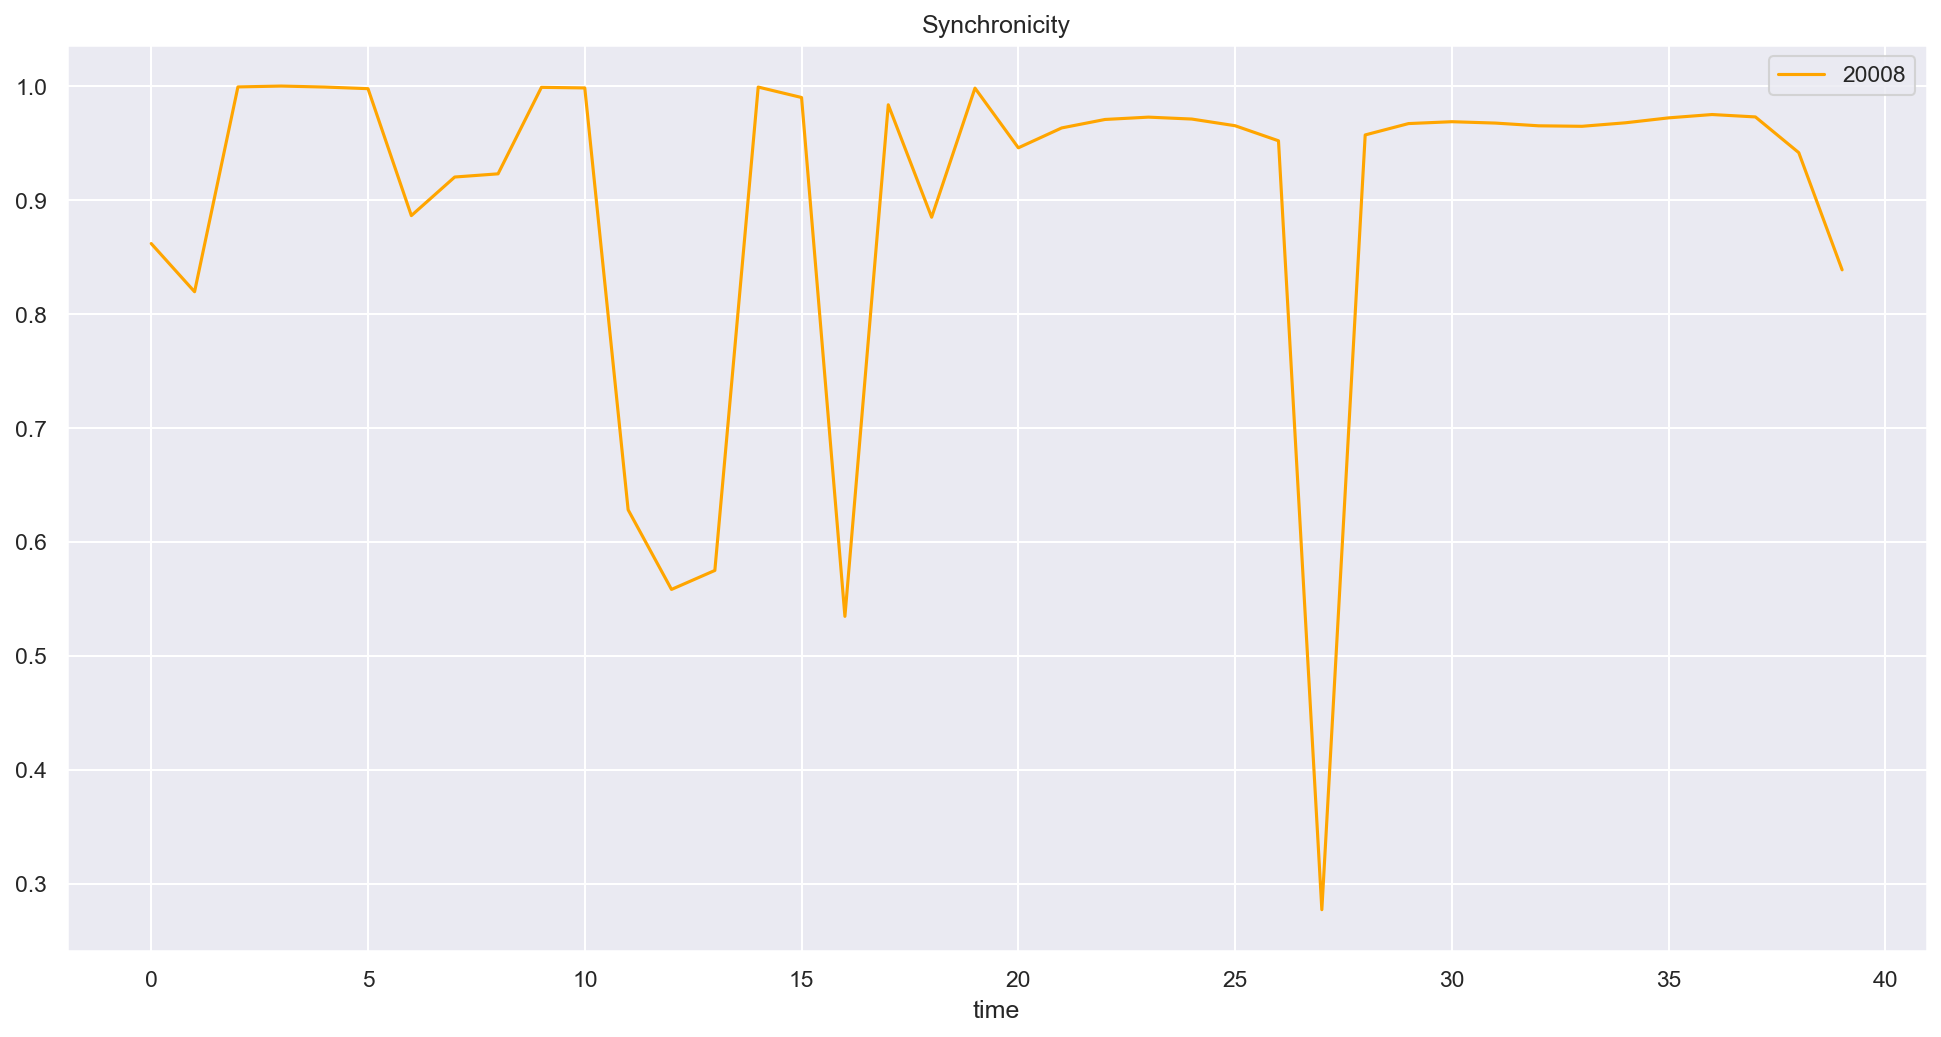

In [56]:
plt.figure(figsize=(16, 8), dpi=150)

# sync_df.loc[sync_df['sub'] == '20001'][frq].plot(label='20001', color = 'red')
# sync_df.loc[sync_df['sub'] == '20002'][frq].plot(label='20002', color = 'blue')
# sync_df.loc[sync_df['sub'] == '20003'][frq].plot(label='20003', color = 'green')
# sync_df.loc[sync_df['sub'] == '20004'][frq].plot(label='20004', color = 'purple')
sync_df.loc[sync_df['sub'] == '20008'][frq].plot(label='20008', color = 'orange')
# sync_df.loc[sync_df['sub'] == '20010'][frq].plot(label='20010', color = 'black')

# adding title to the plot
plt.title('Synchronicity')

# adding Label to the x-axis
plt.xlabel('time')

# adding legend to the curve
plt.legend()

# K vs. Rt per person and estimate the Kc value 

In [113]:
x1 = np.linspace(0, 6 * np.pi, 1000)
x = np.sin(x1) + 0.6 * np.sin(2.6 * x1)

In [140]:
from scipy.signal import chirp, find_peaks, peak_widths
from numpy import fft as fft
from numpy.fft import rfft
from numpy import argmax, mean, diff, log, nonzero
from scipy.signal import blackmanharris, correlate
from time import time
import sys


This function takes a signal and the TR. It uses a fourier transform to get the power spectrum and corresponding frequencies. It then finds the largest power peak and gets the frequency of that peak. From that peak it also calculates the fullwidth halfmax 'scale' of the peak. The frequency of the largest peak is the estimated 'natural frequency' the scale is the estimated deviation in the natural frequency. 

In [243]:
def fouryo(data, tr):
    N = len(data)

    yf = fft(data)
    xf = fftfreq(N, 1/tr)
    max_index_col = np.argmax(abs(yf))
    loc = xf[max_index_col]
    
    peaks, _ = find_peaks(yf)
    results_half = peak_widths(yf, peaks, rel_height=0.5)
    scale = results_half[0][max_index_col]
    return({'loc':loc, 'scale':scale,'max':yf[max_index_col], 'freq':xf})


In [224]:
fouryo(phaze[roi]['20008'][frq], tr)

{'dist': array([ 0.29488298,  2.34346902, -0.88226521, ..., -0.82186277,
        -0.13243834,  0.55797166]),
 'loc': 0.1,
 'scale': 0.6745511529553472,
 'max': (30.500861664906456-6.830075309096054j),
 'freq': 0.1}

In [62]:
from scipy.signal import chirp, find_peaks, peak_widths
from numpy import fft as fft
from numpy.fft import rfft
from numpy import argmax, mean, diff, log, nonzero
from scipy.signal import blackmanharris, correlate
from time import time
import sys





In [225]:
import random


This function uses the above function and then calculates a Kuramoto model based on the estimated natural frequencies. It then takes the model and applies it to a 2 node graph

In [286]:
def findKC(roi,sub,tr,frq):
    wave1 = in_sync[sub]
    wave2 = phaze[roi][sub][frq]
    graph_nx = nx.erdos_renyi_graph(n=2, p=1) # p=1 -> all-to-all connectivity
    graph = nx.to_numpy_array(graph_nx)
    coupling_vals = np.linspace(0, 0.6, 100)
    RR = []
    KC = []
    runs = []
    mods = []
    nat1 = fouryo(wave1, tr)
    nat2 = fouryo(wave2, tr)
    natfreq = np.array([nat1['loc'],nat2['loc']])
    for coupling in coupling_vals:
        model = Kuramoto(coupling=coupling, dt=0.1, T=27, natfreqs=natfreq)
        act_mat = model.run(adj_mat=graph)
        runs.append(act_mat) 
        mods.append(model)
    runs_array = np.array(runs)
    for i,coupling in enumerate(coupling_vals):
        r_mean = np.mean([mods[i].phase_coherence(vec) for vec in runs_array[i, :, -1000:].T]) # mean over last 1000 steps
        RR.append(r_mean)
    Kc = np.sqrt(8 / np.pi) * np.std(model.natfreqs)
    return({'Kc':Kc,'r_means':RR,'coupling_vals':coupling_vals,'roi_nat':nat2, 'insulin_nat':nat1, 'model':mods,'runs':runs})



In [287]:
frq = 'IMF3: 0.063–0.098 Hz'
roi = 'HTH'
tr = 1
model_params = {}
for sub,data in phaze[roi].items():
    model_params[sub]=findKC(roi,sub,tr,frq)
    

In [288]:
model_params['20008']['roi_nat']

{'loc': 0.1,
 'scale': 0.6745511529553472,
 'max': (30.500861664906456-6.830075309096054j),
 'freq': array([ 0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,
         0.2  ,  0.225,  0.25 ,  0.275,  0.3  ,  0.325,  0.35 ,  0.375,
         0.4  ,  0.425,  0.45 ,  0.475, -0.5  , -0.475, -0.45 , -0.425,
        -0.4  , -0.375, -0.35 , -0.325, -0.3  , -0.275, -0.25 , -0.225,
        -0.2  , -0.175, -0.15 , -0.125, -0.1  , -0.075, -0.05 , -0.025])}

In [289]:
model_params['20008']['insulin_nat']

{'loc': 0.025,
 'scale': 1.7890753426703045,
 'max': (-18.213721024191106+22.929447208400138j),
 'freq': array([ 0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,
         0.2  ,  0.225,  0.25 ,  0.275,  0.3  ,  0.325,  0.35 ,  0.375,
         0.4  ,  0.425,  0.45 ,  0.475, -0.5  , -0.475, -0.45 , -0.425,
        -0.4  , -0.375, -0.35 , -0.325, -0.3  , -0.275, -0.25 , -0.225,
        -0.2  , -0.175, -0.15 , -0.125, -0.1  , -0.075, -0.05 , -0.025])}

In [290]:
for sub,data in model_params.items():
    print('%s %s'%(sub,data['Kc']))

20008 0.059841342060214915
20001 0.01994711402007164
20002 0.03989422804014326
20003 0.03989422804014328
20004 0.03989422804014328
20010 0.059841342060214915


Coupling can occur at a lower K in individuals with better insulin sensitivity

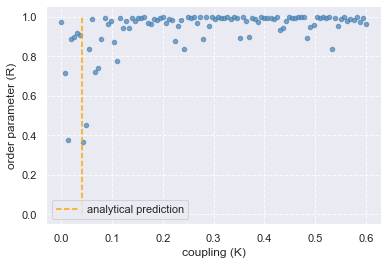

In [294]:
sub = '20003'
plt.figure()
plt.scatter(model_params[sub]['coupling_vals'], model_params[sub]['r_means'], c='steelblue', s=20, alpha=0.7)
plt.vlines(model_params[sub]['Kc'], 0, 1, linestyles='--', color='orange', label='analytical prediction')

plt.legend()
plt.grid(linestyle='--', alpha=0.8)
plt.ylabel('order parameter (R)')
plt.xlabel('coupling (K)')
sns.despine()

In [295]:
adillyofapickle('/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output',model_params, 'model_params')

already have tmp


## Saving the data to csv files to make nicer graphs in R

In [30]:
basepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data'

In [31]:
for roi, dat in faze.items():
    sync_df = []
    for sub, data in dat.items():
        x = pd.DataFrame.from_dict(data)
        x['sub'] = sub
        x['time'] = time[roi]
        x['time'] = pd.to_datetime(x['time'])
        x['time'] = x['time'].dt.strftime('%H:%M:%S')
        x = x.set_index('time')
        sync_df.append(x)
    sync_df = pd.concat(sync_df)
    sync_df.to_csv(os.path.join(basepath,'derivatives','output','dfs','sync_%s.csv'%roi))  

In [32]:
for roi, dat in kura.items():
    k_df = []
    for sub, data in kura[roi].items():
        x = pd.DataFrame.from_dict(data)
        x['sub'] = sub
        x['time'] = time[roi]
        x['time'] = pd.to_datetime(x['time'])
        x['time'] = x['time'].dt.strftime('%H:%M:%S')
        x = x.set_index('time')
        k_df.append(x)
    kura_df = pd.concat(k_df)
    kura_df.to_csv(os.path.join(basepath,'derivatives','output','dfs','kuramoto_%s.csv'%roi))  